In [12]:
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

output_csv = f'{res_dir}_celltypes_logreg_April4.csv'
print(output_csv)

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'

# allen tree
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/_celltypes_logreg_April4.csv


In [4]:
%%time
# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
# print(data)
    
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)

# allen tree
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)

from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 478 ms, sys: 153 ms, total: 631 ms
Wall time: 633 ms


In [5]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
data = data[cond_cells]
data

View of AnnData object with n_obs × n_vars = 44075 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [6]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_data = np.array(data.layers['norm_cell'])
X_refdata = np.array(ref_data.X)
Y_refdata = ref_data.obs[levels].values

print(levels, X_data.shape, X_refdata.shape, Y_refdata.shape)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']
['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label'] (44075, 24) (73347, 24) (73347, 3)


# run

In [35]:
class CellTypeClassify(object):
    def __init__(self,
                 X_refdata,
                 y_refdata,
                 X_data,
                 model=None,
                 verbose=True,
                ):
        """
        """
        self.verbose = verbose
        self.model = model
        self.X_refdata = np.array(X_refdata).copy()
        self.y_refdata = np.array(y_refdata).copy() 
        self.X_data = np.array(X_data).copy()
        
        # # got at the end of the run
        # self.y_data

    def run(self, norm=True, n_cells=100):
        self.normalizeData(norm=norm)
        self.classBalance(n_cells=n_cells)
        self.buildModel()
        
        self.trainModel()
        self.predictLabels()
        return self.y_data
    
    def run2(self):
        # self.normalizeData(norm=norm)
        # self.classBalance(n_cells=n_cells)
        # norm
        Xtrain = self.X_refdata.copy()
        Xtrain = Xtrain/np.sum(Xtrain, axis=1).reshape(-1,1)
        ytrain = self.y_refdata
        
        Xtest = self.X_data.copy()
        Xtest = Xtest/np.sum(Xtest, axis=1).reshape(-1,1)
        
        # train
        self.model.fit(Xtrain, ytrain)
        # predict
        ytest = model.predict(Xtest)
        return ytest
    
    def buildModel(self):
        # default model
        if self.model == None:
            self.model = KNeighborsClassifier(n_neighbors=15, metric='correlation')
        # other wise uses the user input
        
    def normalizeData(self, norm=True):
        if norm:
            self.Xnorm_data = basicu.zscore(self.X_data, axis=0)
            self.Xnorm_refdata = basicu.zscore(self.X_refdata, axis=0) # across rows (0) for each column
        else:
            self.Xnorm_data = self.X_data
            self.Xnorm_refdata = self.X_refdata

    def classBalance(self, n_cells=100):
        """ Class Balance 
        select `n_cells` from each cluster without replacement
        if n_cells > cluster size, it selects **all** cells 
        """
        # sample
        if n_cells > 0:
            _df = pd.Series(self.y_refdata).to_frame('label')
            idx = basicu.stratified_sample(_df, 'label', n_cells).sort_index().index.values
            
            self.Xbalanced_refdata = self.Xnorm_refdata[idx,:]
            self.ybalanced_refdata = self.y_refdata[idx]
        else:
            self.Xbalanced_refdata = self.Xnorm_refdata
            self.ybalanced_refdata = self.y_refdata
        
    def trainModel(self):
        self.model.fit(self.Xbalanced_refdata, self.ybalanced_refdata)
        
    def predictLabels(self):
        self.y_data = self.model.predict(self.Xnorm_data)
        

def iterative_classify(
                 X_refdata,
                 Y_refdata,
                 X_data,
                 levels,
                 model=None,
                 verbose=True,
                 run_func='run',
                 **run_kwargs,
                 ):
    """
    """
    y_data = np.empty((len(X_data),len(levels)), dtype=object)

    for _iter, level in enumerate(levels):
        logging.info(f'iteration {_iter+1}/{len(levels)}')
        ### one iteration
        if _iter == 0:
            next_rounds  = [f'level_{_iter}']
            next_rounds_idx_refdata = [np.arange(len(X_refdata))]
            next_rounds_idx_data = [np.arange(len(X_data))]

        # update current to next
        curr_rounds = next_rounds
        curr_rounds_idx_refdata = next_rounds_idx_refdata
        curr_rounds_idx_data = next_rounds_idx_data

        # update next to empty
        next_rounds = []
        next_rounds_idx_refdata = []
        next_rounds_idx_data = []

        # go over each current round
        for _round, idx_refdata, idx_data in zip(curr_rounds, 
                                                 curr_rounds_idx_refdata,
                                                 curr_rounds_idx_data,
                                                ):
            logging.info(f'Current round: {_round}')
            # this round
            local_X_refdata = X_refdata[idx_refdata,:]
            local_y_refdata = Y_refdata[:,_iter][idx_refdata]
            local_X_data = X_data[idx_data,:]
            rc = CellTypeClassify(
                             local_X_refdata,
                             local_y_refdata,
                             local_X_data,
                             model=model,
                             verbose=verbose,
                             )
            try:
                local_y_data = getattr(rc, run_func)(**run_kwargs)
                # catch results
                y_data[idx_data, _iter] = local_y_data
                
                # set up for the next round
                y_data_unique = np.unique(local_y_data)
                for cluster in y_data_unique:
                    next_rounds.append(f'level_{_iter+1}_cluster_{cluster}')
                    next_rounds_idx_refdata.append(idx_refdata[(local_y_refdata == cluster)])
                    next_rounds_idx_data.append(idx_data[(local_y_data == cluster)])
            except:
                logging.info(f'Failed splitting: {_round}')
                # y_data[idx_data, _iter] = ''
                
    return y_data

In [36]:
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# model = RandomForestClassifier()

model = LogisticRegression(penalty='none')

In [37]:
# run
# y_data = celltypeu.iterative_classify(
#                  X_refdata,
#                  Y_refdata,
#                  X_data,
#                  levels,
#                  model=model,
#                  verbose=True,
#                  n_cells=0,
# )
y_data = iterative_classify(
                 X_refdata,
                 Y_refdata,
                 X_data,
                 levels,
                 model=model,
                 verbose=True,
                 run_func='run2',
)

INFO:root:iteration 1/3
INFO:root:Current round: level_0
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

INFO:root:iteration 2/3
INFO:root:Current round: level_1_cluster_GABAergic
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refe

# Evaluate and save 

In [38]:
res = data.obs.copy() #pd.DataFrame(index=data.obs.index)
for i, level in enumerate(levels):
    res[level] = y_data[:,i]
res

,label,pixel_x,pixel_y,nuclei_size,nuclei_signal,cytoplasm_size,cytoplasm_signal,total_size,total_signal,posname,...,stage_x,stage_y,coord_x,coord_y,region_id,region_color,region_acronym,Level_1_class_label,Level_2_neighborhood_label,Level_3_subclass_label
DPNMF_PolyA_2021Nov19_Pos3_cell_1.0,1.0,6.946154,13.064102,390.0,37376.0,94.0,26496.0,479.0,35312.0,Pos3,...,-2412.264446,-3414.258897,-3836.669362,257.071979,366,#15B0B3,TEa6a,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_2.0,2.0,11.731343,96.792404,737.0,36368.0,146.0,26160.0,873.0,34224.0,Pos3,...,-2413.824418,-3441.554324,-3864.007917,257.349850,366,#15B0B3,TEa6a,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_3.0,3.0,8.584210,230.557892,380.0,42064.0,132.0,34464.0,390.0,38992.0,Pos3,...,-2412.798453,-3485.161873,-3907.519336,254.279457,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_5.0,5.0,7.058411,385.787384,428.0,46496.0,143.0,39760.0,566.0,45040.0,Pos3,...,-2412.301042,-3535.766687,-3958.045112,251.408807,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_7.0,7.0,9.555555,576.148865,477.0,6816.0,19.0,6400.0,475.0,6832.0,Pos3,...,-2413.115111,-3597.824530,-4020.072828,249.310951,365,#15B0B3,TEa5,Glutamatergic,L2/3 IT,L3 IT ENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,1351.0,2025.603882,2292.653809,260.0,7744.0,220.0,8176.0,474.0,7888.0,Pos102,...,-409.346865,2777.594858,2442.321904,-1453.191293,463,#7ED04B,CA2,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,1352.0,2031.969238,2012.783447,651.0,7664.0,114.0,7024.0,651.0,7248.0,Pos102,...,-411.421972,2868.832596,2533.361867,-1446.838662,463,#7ED04B,CA2,Non-Neuronal,None,None
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,1353.0,2031.924072,2435.701660,382.0,4432.0,126.0,4672.0,508.0,4560.0,Pos102,...,-411.407248,2730.961259,2395.642989,-1453.320683,463,#7ED04B,CA2,Non-Neuronal,None,None
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,1356.0,2033.539062,2311.605469,256.0,8960.0,367.0,9360.0,629.0,9184.0,Pos102,...,-411.933734,2771.416617,2436.029118,-1450.897083,463,#7ED04B,CA2,Non-Neuronal,None,None


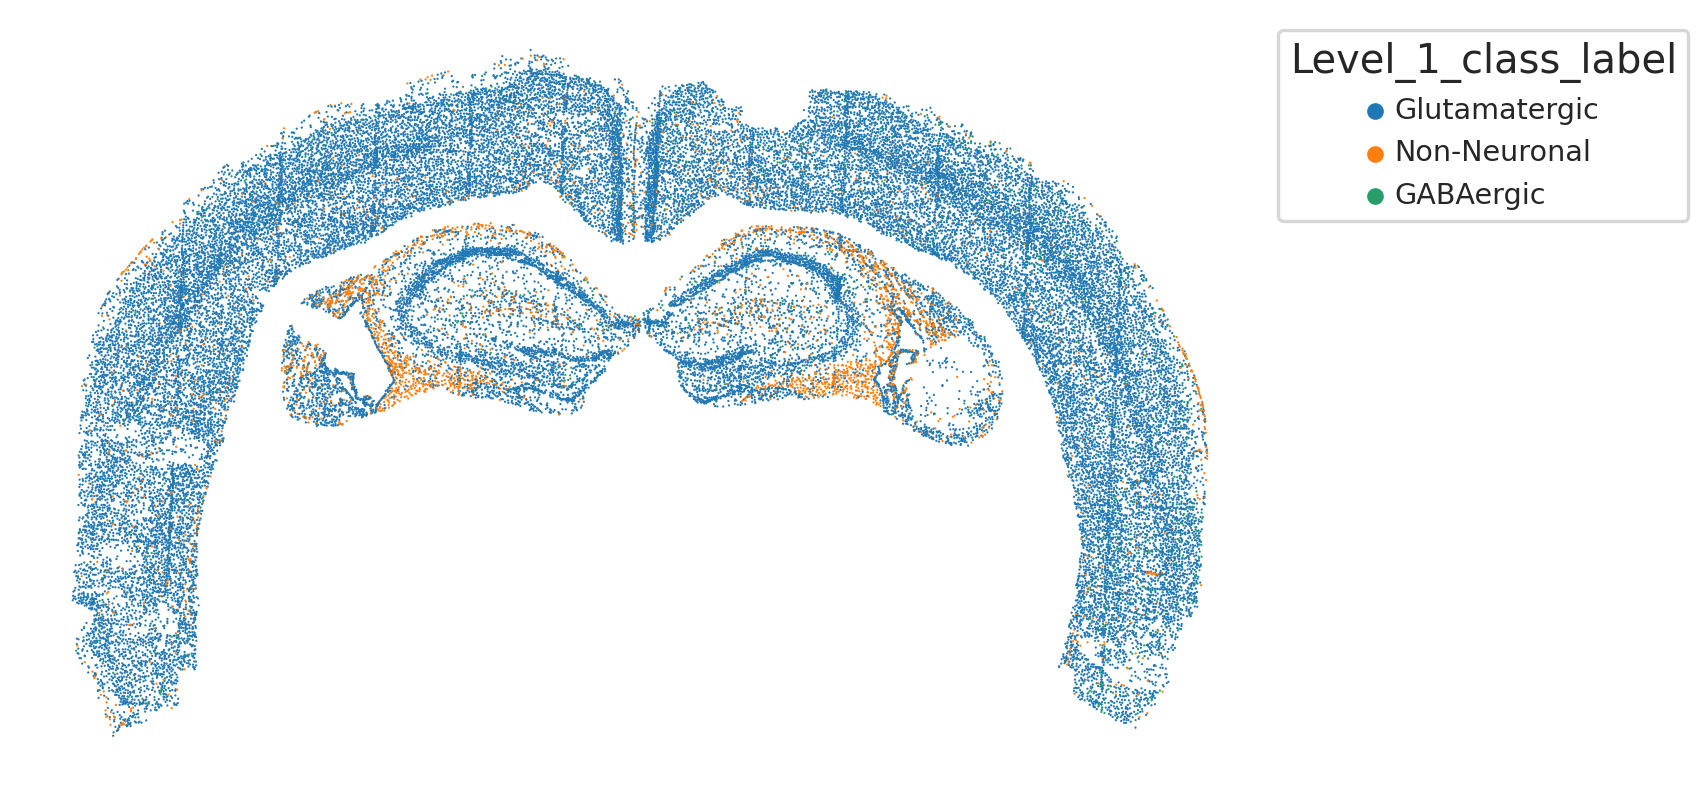

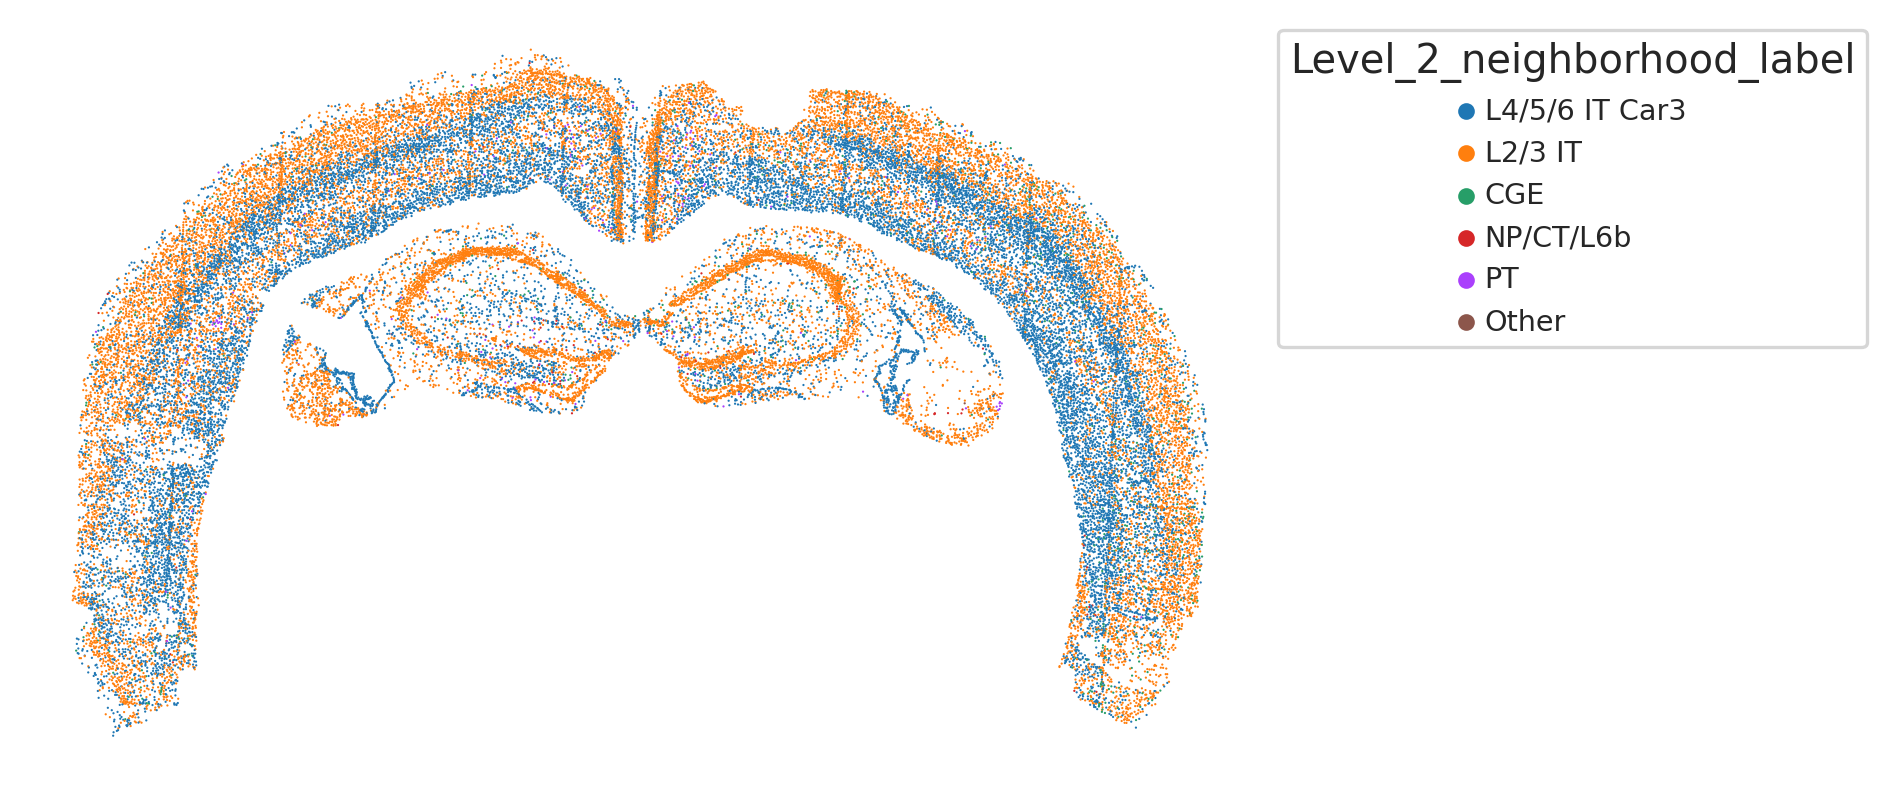

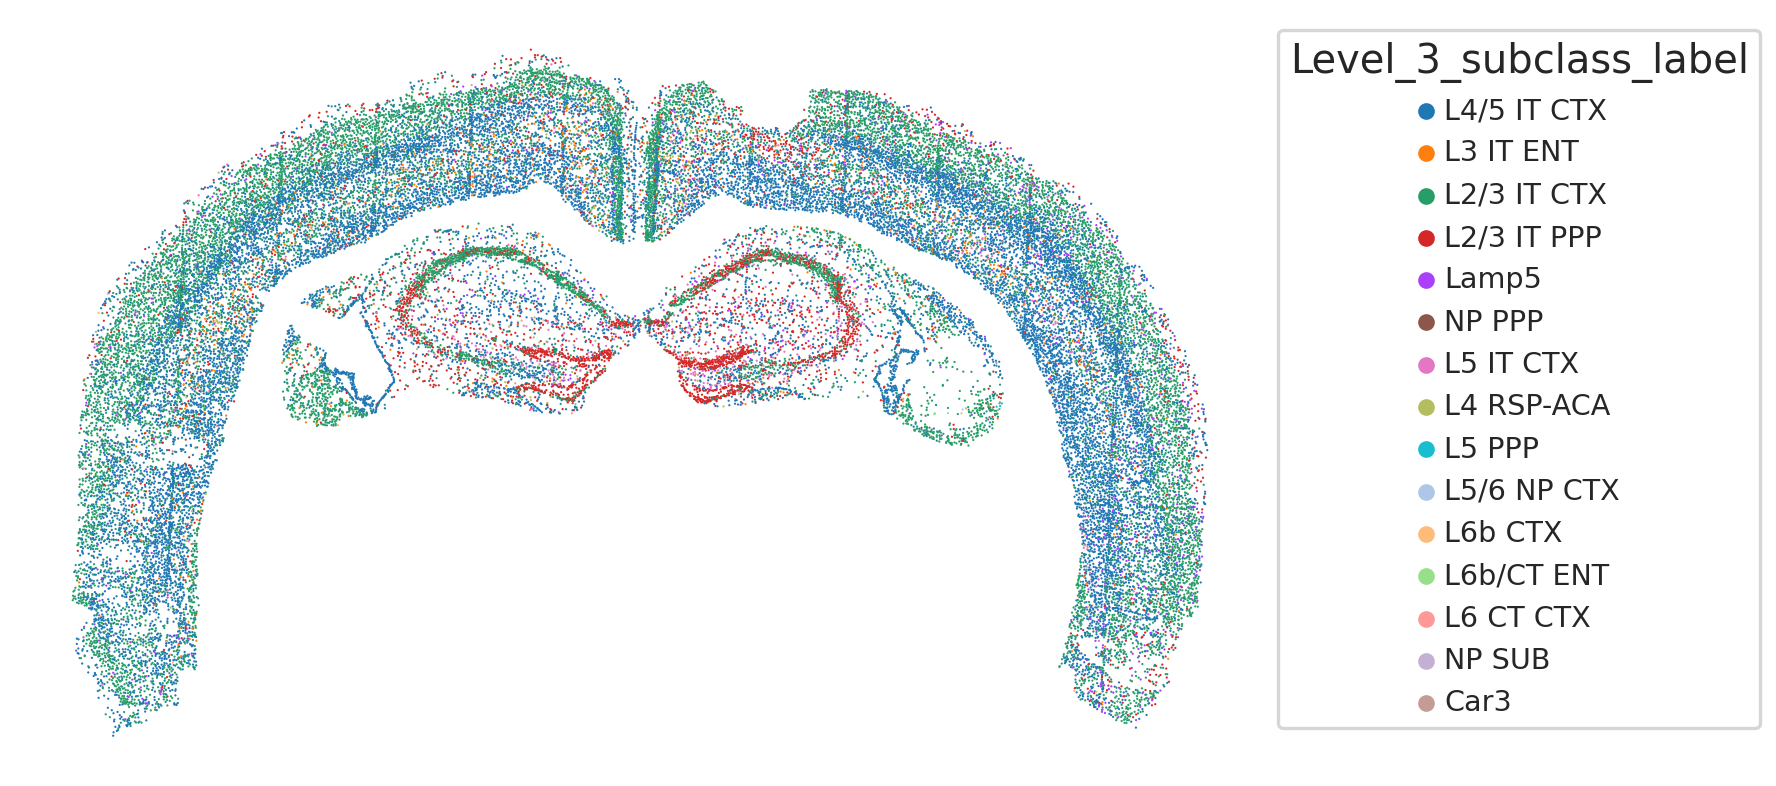

In [39]:
for level in levels:
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=res, x='coord_x', y='coord_y', hue=level,
                    # hue_order=np.sort(np.unique(res[level])),
                    s=1,
                    edgecolor='none',
                    rasterized=True,
                   )
    ax.axis('off')
    ax.legend(bbox_to_anchor=(1,1), 
              loc='upper left', 
              # ncol=1+int(len(np.unique(res[level]))/20), 
              title=level,
             )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()

In [40]:
# res.to_csv(output_csv, header=True, index=True)

In [41]:
# !head $output_csv
!wc -l $output_csv

wc: /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/_celltypes_logreg_April4.csv: No such file or directory


In [42]:
!head $output_csv

head: cannot open '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/_celltypes_logreg_April4.csv' for reading: No such file or directory


# Evaluation -- file paths and load data

In [43]:
# # input_celltypes = f'{res_dir}noHarmony_March30_v4_isocortex_hpf.csv'
# # print(input_celltypes)
input_embed1 = f'{res_dir}Joint_UMAP_isocortex_hpf_April1.csv'
print(input_embed1)
input_embed2 = f'{res_dir}Joint_UMAP_isocortex_hpf_subsamp100_level1_April1.csv'
print(input_embed2)

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'


/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_April1.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_subsamp100_level1_April1.csv


In [44]:
# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)

In [46]:
# results
dftypes = res.copy() #pd.read_csv(input_celltypes, index_col=0)
dftypes = dftypes.filter(regex=r'^Level_[0-9]', axis=1)
levels = dftypes.columns.values

# update data
# data.obs = data.obs.join(dftypes)
for level in levels:
    if level in data.obs.columns.values:
        data.obs = data.obs.drop(level, axis=1)
data.obs = data.obs.join(dftypes)

# update the joint one
dfembed1 = pd.read_csv(input_embed1, index_col=0)
dfembed2 = pd.read_csv(input_embed2, index_col=0)
dfembed1 = dfembed1.join(pd.concat([data.obs, ref_data.obs]))
dfembed2 = dfembed2.join(pd.concat([data.obs, ref_data.obs]))

print(dftypes.shape, dfembed1.shape, dfembed2.shape, data.obs.shape)

(44075, 3) (117422, 79) (44375, 79) (44075, 23)


# Organize information

In [47]:
resobj = evalu.Level3Res(meta, levels, 
                ref_data, data, 
                refdata_name='scRNA-seq', data_name='dredFISH',
                embed=True, df_embed=dfembed1,
               )

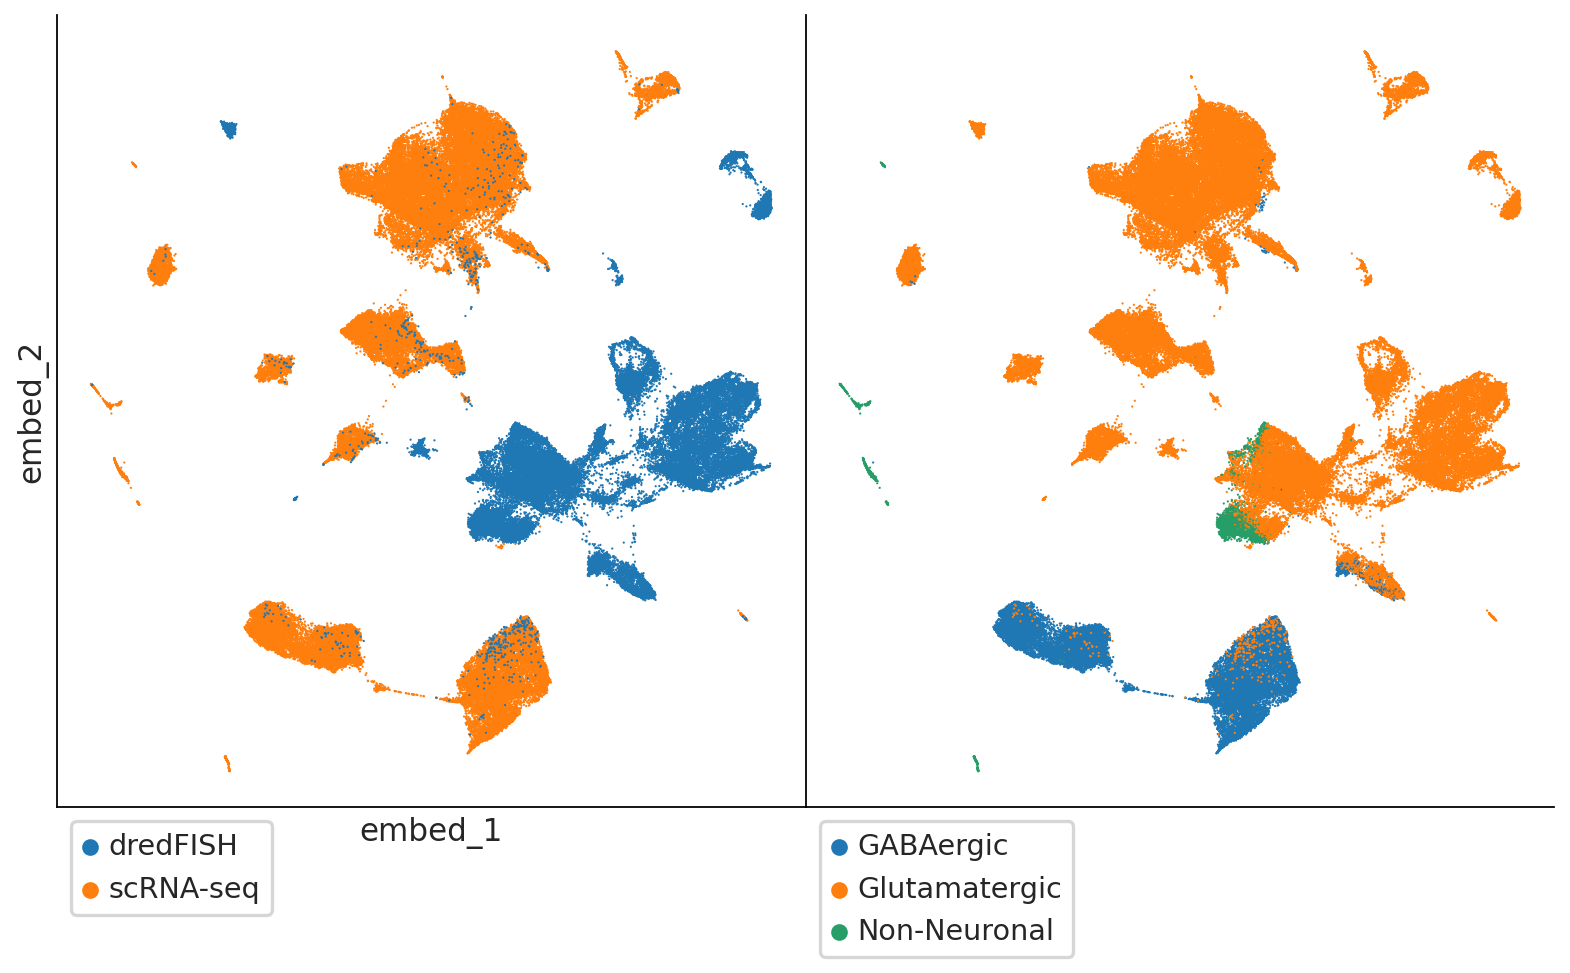

ValueError: negative row index found

In [49]:

# embed eval
resobj.plot_embeds(hues=['dataset']+levels[:1].tolist())

# gene eval
resobj.plot_genes()

# spatial eval
resobj.plot_spatial()
